# Undertanding the IMDB Reviews Data Set

Instructions
* You will need to make a new virtual enviroment so that the libraries we are going to use will work
    * Steps to create a virtual enviroment:
        * Go to the project directory and run this command:
            * python -m venv IMDB_ven
        * Then on MacOS, type this command:
            * source IMDB_ven/bin/activate
        * On Windows, type this command:
            * IMDB_ven\Scripts\activate
        * Now we are in the virtual enviroment
* Then download the libraries using the requirements.txt file, we will continue to add to this file if we need more libraries in our project
    * Run this command in your terminal to download the libraries:
        * pip install -r requirements.txt
* Now lets open the aclImdb_v1.tar.gz file
    * We can use the tar command to open up the file:
        * tar -xzvf aclImdb_v1.tar.gz
            * -x: Extracts the files
            * -z: Unzips the gzipped file
            * -v: Verbosely lists the files being extracted
            * -f: Specifies the file name
* Word of caution:
    * After unzipping the file please do not push the acllmdb file to the github repository since it is very large, that means typing 'git add .' will add this file to the github repository (by basically adding everything) so avoid using the '.'
    * Instead just add the files you would like to push by doing 'git add <name_of_file_you_want_to_push>'
    * Do not add the aclImdb_v1.tar.gz to github, just have this file in your local enviroment

In [1]:
'''
# Checking if CUDA is enabled

import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
    
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
'''

'\n# Checking if CUDA is enabled\n\nimport torch\n\nprint(f"Is CUDA supported by this system? {torch.cuda.is_available()}")\nprint(f"CUDA version: {torch.version.cuda}")\n\n# Storing ID of current CUDA device\ncuda_id = torch.cuda.current_device()\nprint(f"ID of current CUDA device: {torch.cuda.current_device()}")\n    \nprint(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")\n'

# Part 1: Understanding the Data #


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud  
from sklearn.model_selection import train_test_split

# these libraries are used for the text cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#these libraries are building the model
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn.functional import softmax
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler

# seed for reproducibility
seed = 1111

In [3]:
# have a seperate helper function to load reviews from a folder
def load_reviews(folder_path, label):
    reviews = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            reviews.append(file.read())
    return pd.DataFrame({"review": reviews, "label": label})

The following code block for data loading and unloading, only needs to be ran once

In [4]:
'''
# here we will store the base path to the dataset, then load the positive and negative reviews from the training data set to a dataframe
base_path = "aclImdb"

# since this is a classification problem, we will give pos reviews a 1 and neg reviews a 0
train_pos = load_reviews(os.path.join(base_path, "train/pos"), label=1)
train_neg = load_reviews(os.path.join(base_path, "train/neg"), label=0)
train_data = pd.concat([train_pos, train_neg]).reset_index(drop=True)

test_pos = load_reviews('./aclImdb/test/pos', label=1)
test_neg = load_reviews('./aclImdb/test/neg', label=0)
test_data = pd.concat([test_pos, test_neg]).reset_index(drop=True)

full_data = pd.concat([train_data, test_data]).reset_index(drop=True)

# save dataframes to a csv files
train_data.to_csv("train_review_data.csv", index=False)
test_data.to_csv("test_review_data.csv", index=False)
full_data.to_csv("full_review_data.csv", index=False)
'''

'\n# here we will store the base path to the dataset, then load the positive and negative reviews from the training data set to a dataframe\nbase_path = "aclImdb"\n\n# since this is a classification problem, we will give pos reviews a 1 and neg reviews a 0\ntrain_pos = load_reviews(os.path.join(base_path, "train/pos"), label=1)\ntrain_neg = load_reviews(os.path.join(base_path, "train/neg"), label=0)\ntrain_data = pd.concat([train_pos, train_neg]).reset_index(drop=True)\n\ntest_pos = load_reviews(\'./aclImdb/test/pos\', label=1)\ntest_neg = load_reviews(\'./aclImdb/test/neg\', label=0)\ntest_data = pd.concat([test_pos, test_neg]).reset_index(drop=True)\n\nfull_data = pd.concat([train_data, test_data]).reset_index(drop=True)\n\n# save dataframes to a csv files\ntrain_data.to_csv("train_review_data.csv", index=False)\ntest_data.to_csv("test_review_data.csv", index=False)\nfull_data.to_csv("full_review_data.csv", index=False)\n'

In [5]:
# load the dataframes
train_data = pd.read_csv("train_review_data.csv",usecols=["review", "label"])
test_data = pd.read_csv("test_review_data.csv", usecols=["review", "label"])
full_data = pd.read_csv("full_review_data.csv", usecols=["review", "label"])

In [6]:
# show the data to get a rough idea of what we have
print("Number of reviews:", len(train_data))
display(train_data)
train_data.info()

Number of reviews: 25000


,review,label
0,Zentropa has much in common with The Third Man...,1
1,Zentropa is the most original movie I've seen ...,1
2,Lars Von Trier is never backward in trying out...,1
3,*Contains spoilers due to me having to describ...,1
4,That was the first thing that sprang to mind a...,1
...,...,...
24995,There just isn't enough here. There a few funn...,0
24996,Tainted look at kibbutz life<br /><br />This f...,0
24997,"I saw this movie, just now, not when it was re...",0
24998,Any film which begins with a cowhand shagging ...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [7]:
print("Number of reviews (test):", len(train_data))
display(test_data)
train_data.info()

Number of reviews (test): 25000


,review,label
0,Previous reviewer Claudio Carvalho gave a much...,1
1,"CONTAINS ""SPOILER"" INFORMATION. Watch this dir...",1
2,This is my first Deepa Mehta film. I saw the f...,1
3,This was a great film in every sense of the wo...,1
4,"A stunningly well-made film, with exceptional ...",1
...,...,...
24995,This is basically your run of the mill violent...,0
24996,"I just caught ""Wild Rebels"" on one of the ""Mys...",0
24997,"If you decide to watch Wild Rebels, don't expe...",0
24998,"""Wild Rebels"" was probably a fun second film a...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [8]:
# we want to check the distribution of the data so that we can identify any imbalanced in the data
print("Label distribution:\n", train_data["label"].value_counts())

Label distribution:
 label
1    12500
0    12500
Name: count, dtype: int64


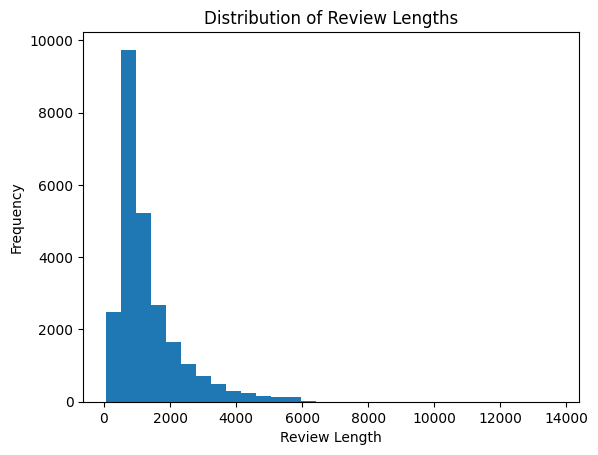

In [9]:
# looks like the data is evenly balanced, so now we want to see how long these reviews are
train_data["review_length"] = train_data["review"].apply(len) # creating a new column that stores the length of the data
plt.hist(train_data["review_length"], bins=30)
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

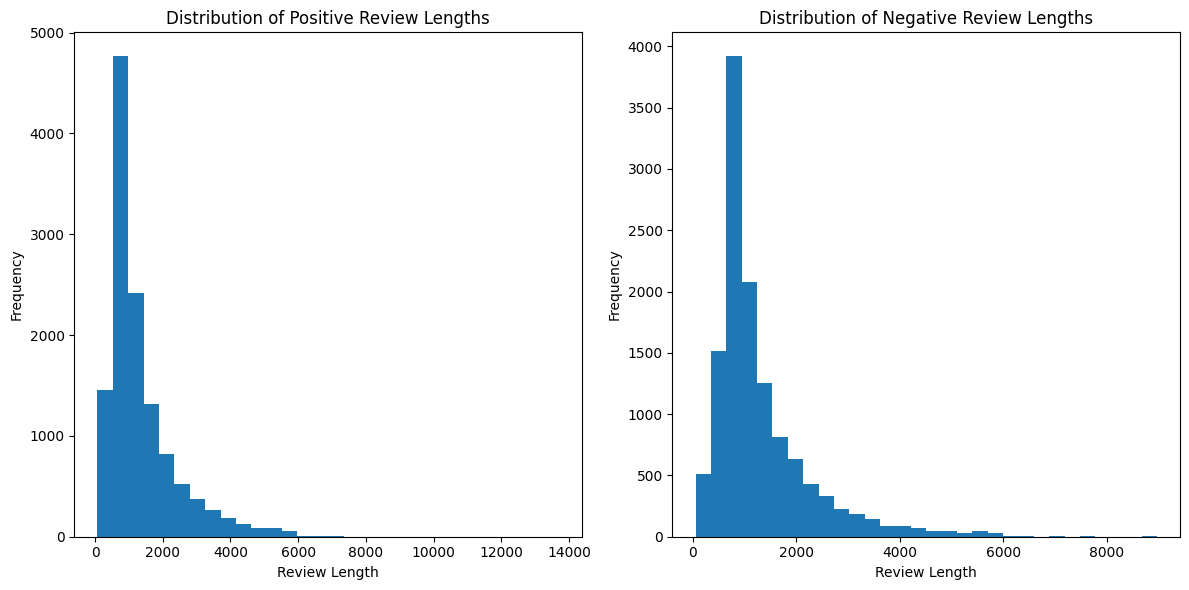

In [10]:
# we can try to see the length of reviews for both the negative and positive reviews as well
pos_reviews = train_data[train_data["label"] == 1]
neg_reviews = train_data[train_data["label"] == 0]

plt.figure(figsize=(12, 6))

# positive reviews
plt.subplot(1, 2, 1) # this graph will be stored in the first row first column
plt.hist(pos_reviews["review_length"], bins=30)
plt.title("Distribution of Positive Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")

# negative reviews
plt.subplot(1, 2, 2) # this graph will be stored in the first row second column
plt.hist(neg_reviews["review_length"], bins=30)
plt.title("Distribution of Negative Review Lengths")
plt.xlabel("Review Length")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [11]:
# it looks like the negative reviews have slightly longer reviews compared to the positive reviews, but at a galnce it does not look like much of a difference
# now I want to display the word frequency of the review data by using the word cloud, but first I will clean the text data and save it as a column to the data frame

# we need to run this bit of code for the cleaning to work, but you only need to run it once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ayonat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ayonat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ayonat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# helper function clean text function to convert text to lowercase, remove special characters
# (punctuation, numbers, etc.), remove stop words, tokenize, and apply lemmatization

def clean_text(text):
  text = text.lower()

  text = re.sub(r'[^a-zA-Z\s]', '', text)

  tokens = word_tokenize(text)

  stop_words = set(stopwords.words("english"))
  tokens = [word for word in tokens if word not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  cleaned_text = ' '.join(tokens)

  return cleaned_text

In [13]:
train_data["cleaned_review"] = train_data["review"].apply(clean_text) # create a new column in our data frame that has the cleaned text so we can use it later
# we wont be using this cleaned text in the BERT model since it would perform poorly on pre cleaned data, so we will just use this for analysis and such


In [14]:
train_data.head()

,review,label,review_length,cleaned_review
0,Zentropa has much in common with The Third Man...,1,728,zentropa much common third man another noirlik...
1,Zentropa is the most original movie I've seen ...,1,673,zentropa original movie ive seen year like uni...
2,Lars Von Trier is never backward in trying out...,1,2187,lars von trier never backward trying new techn...
3,*Contains spoilers due to me having to describ...,1,2544,contains spoiler due describe film technique r...
4,That was the first thing that sprang to mind a...,1,3225,first thing sprang mind watched closing credit...


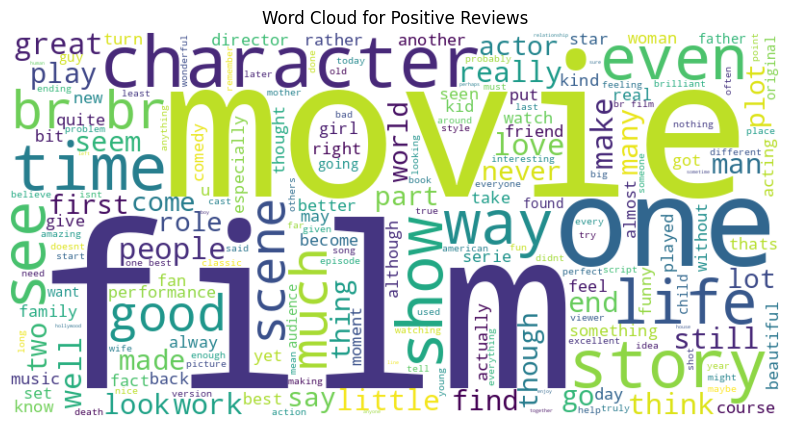

In [15]:
# lets take a look at the word cloud for the positive reviews then the neagtive reviews
pos_text = ' '.join(train_data[train_data["label"] == 1]["cleaned_review"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(pos_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

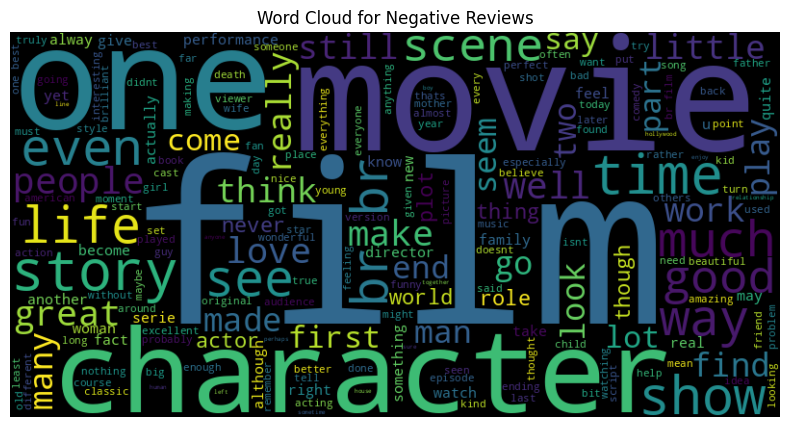

In [16]:
# then the negatvie reviews
neg_text = ' '.join(train_data[train_data["label"] == 0]["cleaned_review"])
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(pos_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [17]:
# take a look at the changes we made to the datafram again here
display(train_data)

,review,label,review_length,cleaned_review
0,Zentropa has much in common with The Third Man...,1,728,zentropa much common third man another noirlik...
1,Zentropa is the most original movie I've seen ...,1,673,zentropa original movie ive seen year like uni...
2,Lars Von Trier is never backward in trying out...,1,2187,lars von trier never backward trying new techn...
3,*Contains spoilers due to me having to describ...,1,2544,contains spoiler due describe film technique r...
4,That was the first thing that sprang to mind a...,1,3225,first thing sprang mind watched closing credit...
...,...,...,...,...
24995,There just isn't enough here. There a few funn...,0,755,isnt enough funny spot really enough disappoin...
24996,Tainted look at kibbutz life<br /><br />This f...,0,3241,tainted look kibbutz lifebr br film less cultu...
24997,"I saw this movie, just now, not when it was re...",0,3126,saw movie released hailed best picture year is...
24998,Any film which begins with a cowhand shagging ...,0,701,film begin cowhand shagging female calf cant p...


# Part 2: Training the Model and Evaluation #

In [18]:
# Load a fine-tuned model for sentiment analysis
model_name = 'textattack/bert-base-uncased-SST-2'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Example text
text1 = 'This is a good movie. I like it'
text2 = 'This is a bad movie. I hate it'

# Tokenize and get predictions
tokens1 = tokenizer(text1, return_tensors='pt', padding=True, truncation=True)
tokens2 = tokenizer(text2, return_tensors='pt', padding=True, truncation=True)

# Get model predictions
result1 = model(**tokens1)
result2 = model(**tokens2)

# Extract the predicted sentiment class (0 = negative, 1 = positive)
sentiment1 = int(torch.argmax(result1.logits))
sentiment2 = int(torch.argmax(result2.logits))

# Output the sentiment labels
sentiment_map = {0: 'Negative', 1: 'Positive'}

print(f'Text 1: {sentiment_map[sentiment1]} \nText 2: {sentiment_map[sentiment2]}')

Text 1: Positive 
Text 2: Negative


In [19]:
# Work with cleaned data
'''
X_train = list(train_data['cleaned_review'])
X_test = list(test_data['cleaned_review'])
Y_train = list(train_data['label'])
Y_test = list(test_data['label'])

#splitting the train set into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=seed)
'''

"\nX_train = list(train_data['cleaned_review'])\nX_test = list(test_data['cleaned_review'])\nY_train = list(train_data['label'])\nY_test = list(test_data['label'])\n\n#splitting the train set into train and validation\nX_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=seed)\n"

In [20]:
X_train = list(train_data['review'])
X_test = list(test_data['review'])
Y_train = list(train_data['label'])
Y_test = list(test_data['label'])

#splitting the train set into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=seed)

In [21]:
# Construct a BERT tokenizer, reutrns a list of input IDs with the appropriate special tokens.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing function
def tokenize_data(texts, tokenizer, max_len=512):
    return tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",  # Pads to max_len
        truncation=True,      # Truncates to max_len
        return_tensors="pt"   # Returns PyTorch tensors
    )

# Tokenize datasets
train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

In [22]:
class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = IMDBDataset(train_encodings, Y_train)
val_dataset = IMDBDataset(val_encodings, Y_val)
test_dataset = IMDBDataset(test_encodings, Y_test)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epochs = 5

# reference: https://stackoverflow.com/questions/60120043/optimizer-and-scheduler-for-bert-fine-tuning
num_training_steps = len(train_loader) * epochs
scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

def train_epoch(model, dataloader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(softmax(logits, dim=1), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

ValueError: SchedulerType.LINEAR requires `num_warmup_steps`, please provide that argument.

# Part 3: Evaluation #

In [ ]:
def evaluate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(softmax(logits, dim=1), dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total

In [ ]:
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
    val_loss, val_acc = evaluate_epoch(model, val_loader, device)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

test_loss, test_acc = evaluate_epoch(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")